In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineDataset, SineCosineDataset, CosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT
from tiny.model import PointDiffusionTransformer
from torch.utils.data import ConcatDataset

In [3]:
num_points = 32
# dataset = SineCosineDataset(num_points=num_points, size=1024)
sine_dataset = SineDataset(num_points=num_points, size=30000)
cosine_dataset = CosineDataset(num_points=num_points, size=30000)
dataset = sine_dataset
dataset = cosine_dataset
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=sine_dataset.collate, batch_size=128, shuffle=True)

In [4]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=1000, learn_sigma=False)
# dit = UnconditionalPointCloudDiT(input_size=num_points, in_channels=2, depth=1, num_heads=1, hidden_size=128).to("cuda")
dit = PointDiffusionTransformer(input_channels=2, 
                                output_channels=2,
                                n_ctx=num_points,
                                heads=1,
                                width=128,
                                device="cuda",
                                layers=1,
                                dtype=torch.float32,
                                )
# dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [5]:
dit(torch.zeros(1, 2, num_points, device="cuda"), torch.tensor([1], device="cuda")).shape
# dit(torch.zeros(1, num_points, 2, device="cuda"), torch.tensor([1], device="cuda")).shape

torch.Size([1, 2, 32])

In [6]:
count_parameters(dit)

331138

In [7]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=250,
    lr=1e-3,
    a=True
)

In [8]:
losses = trainer.train()
plt.semilogy(losses)

[INFO] Model Parameters: 331138


 12%|█▏        | 14621/117250 [01:11<08:32, 200.07it/s, loss=0.216]

Sampling:   8%|▊         | 79/1000 [00:00<00:01, 786.71it/s]

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 979.08it/s]


torch.Size([100, 2, 32])


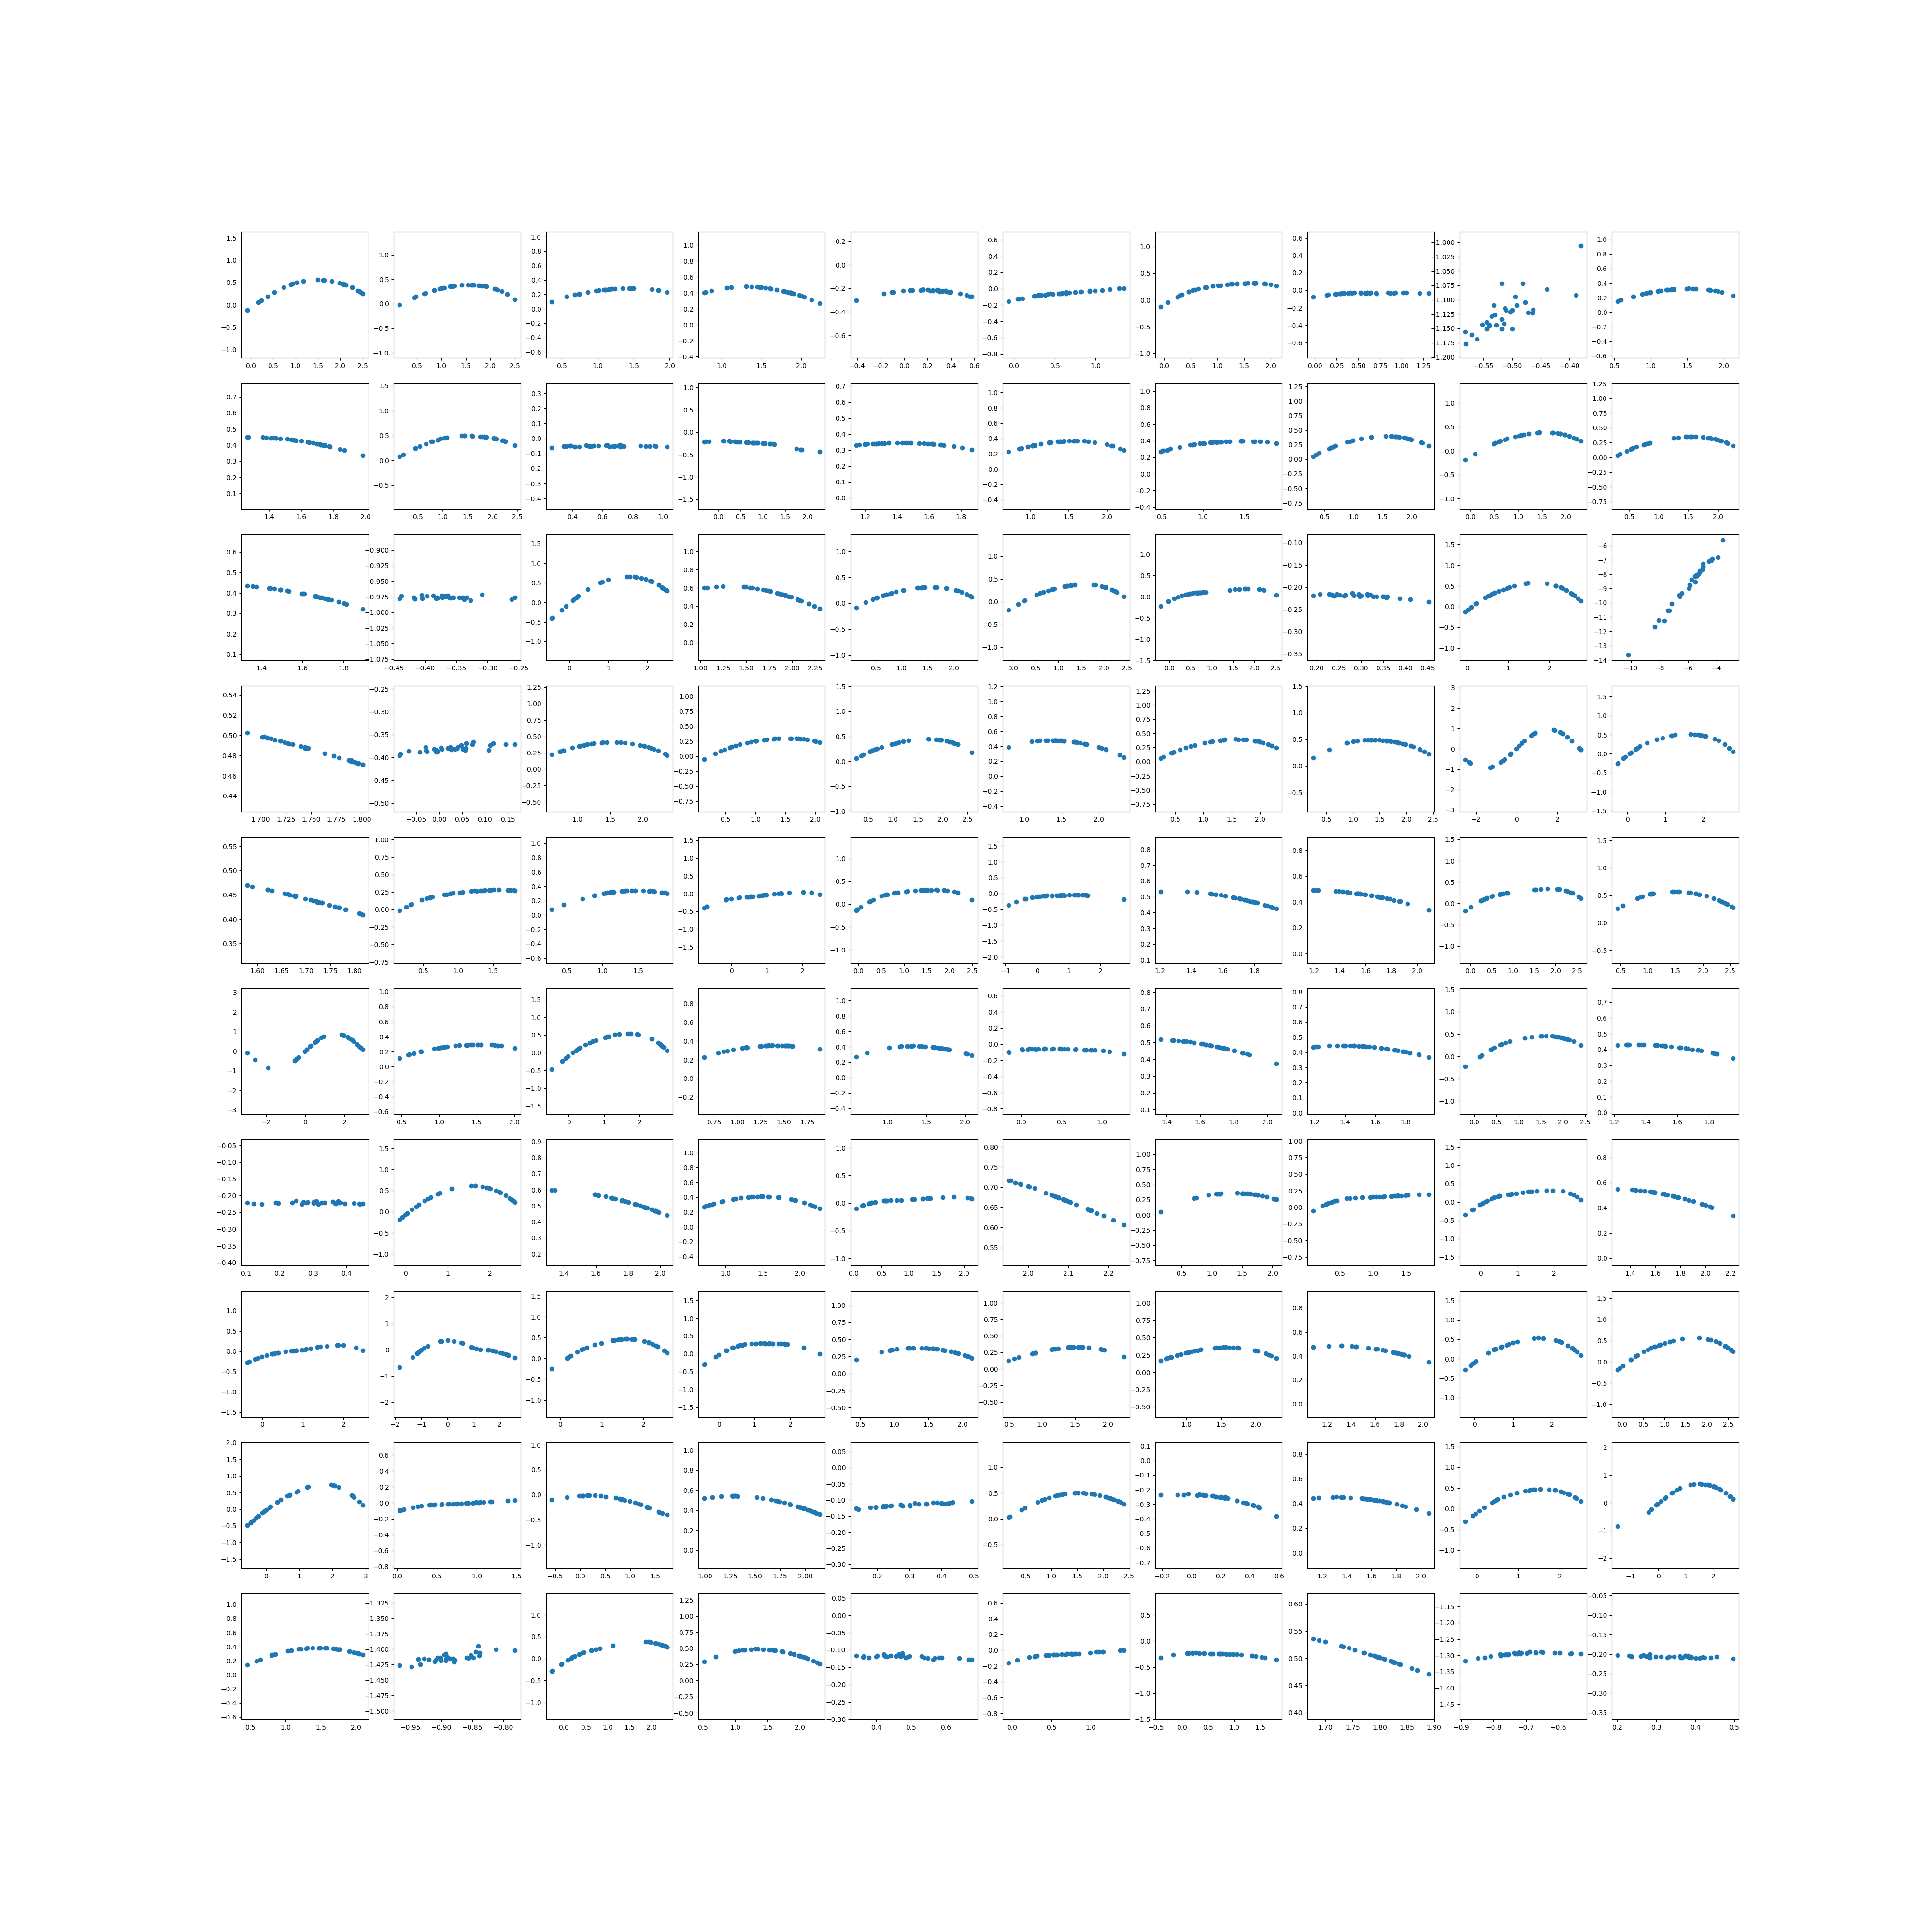

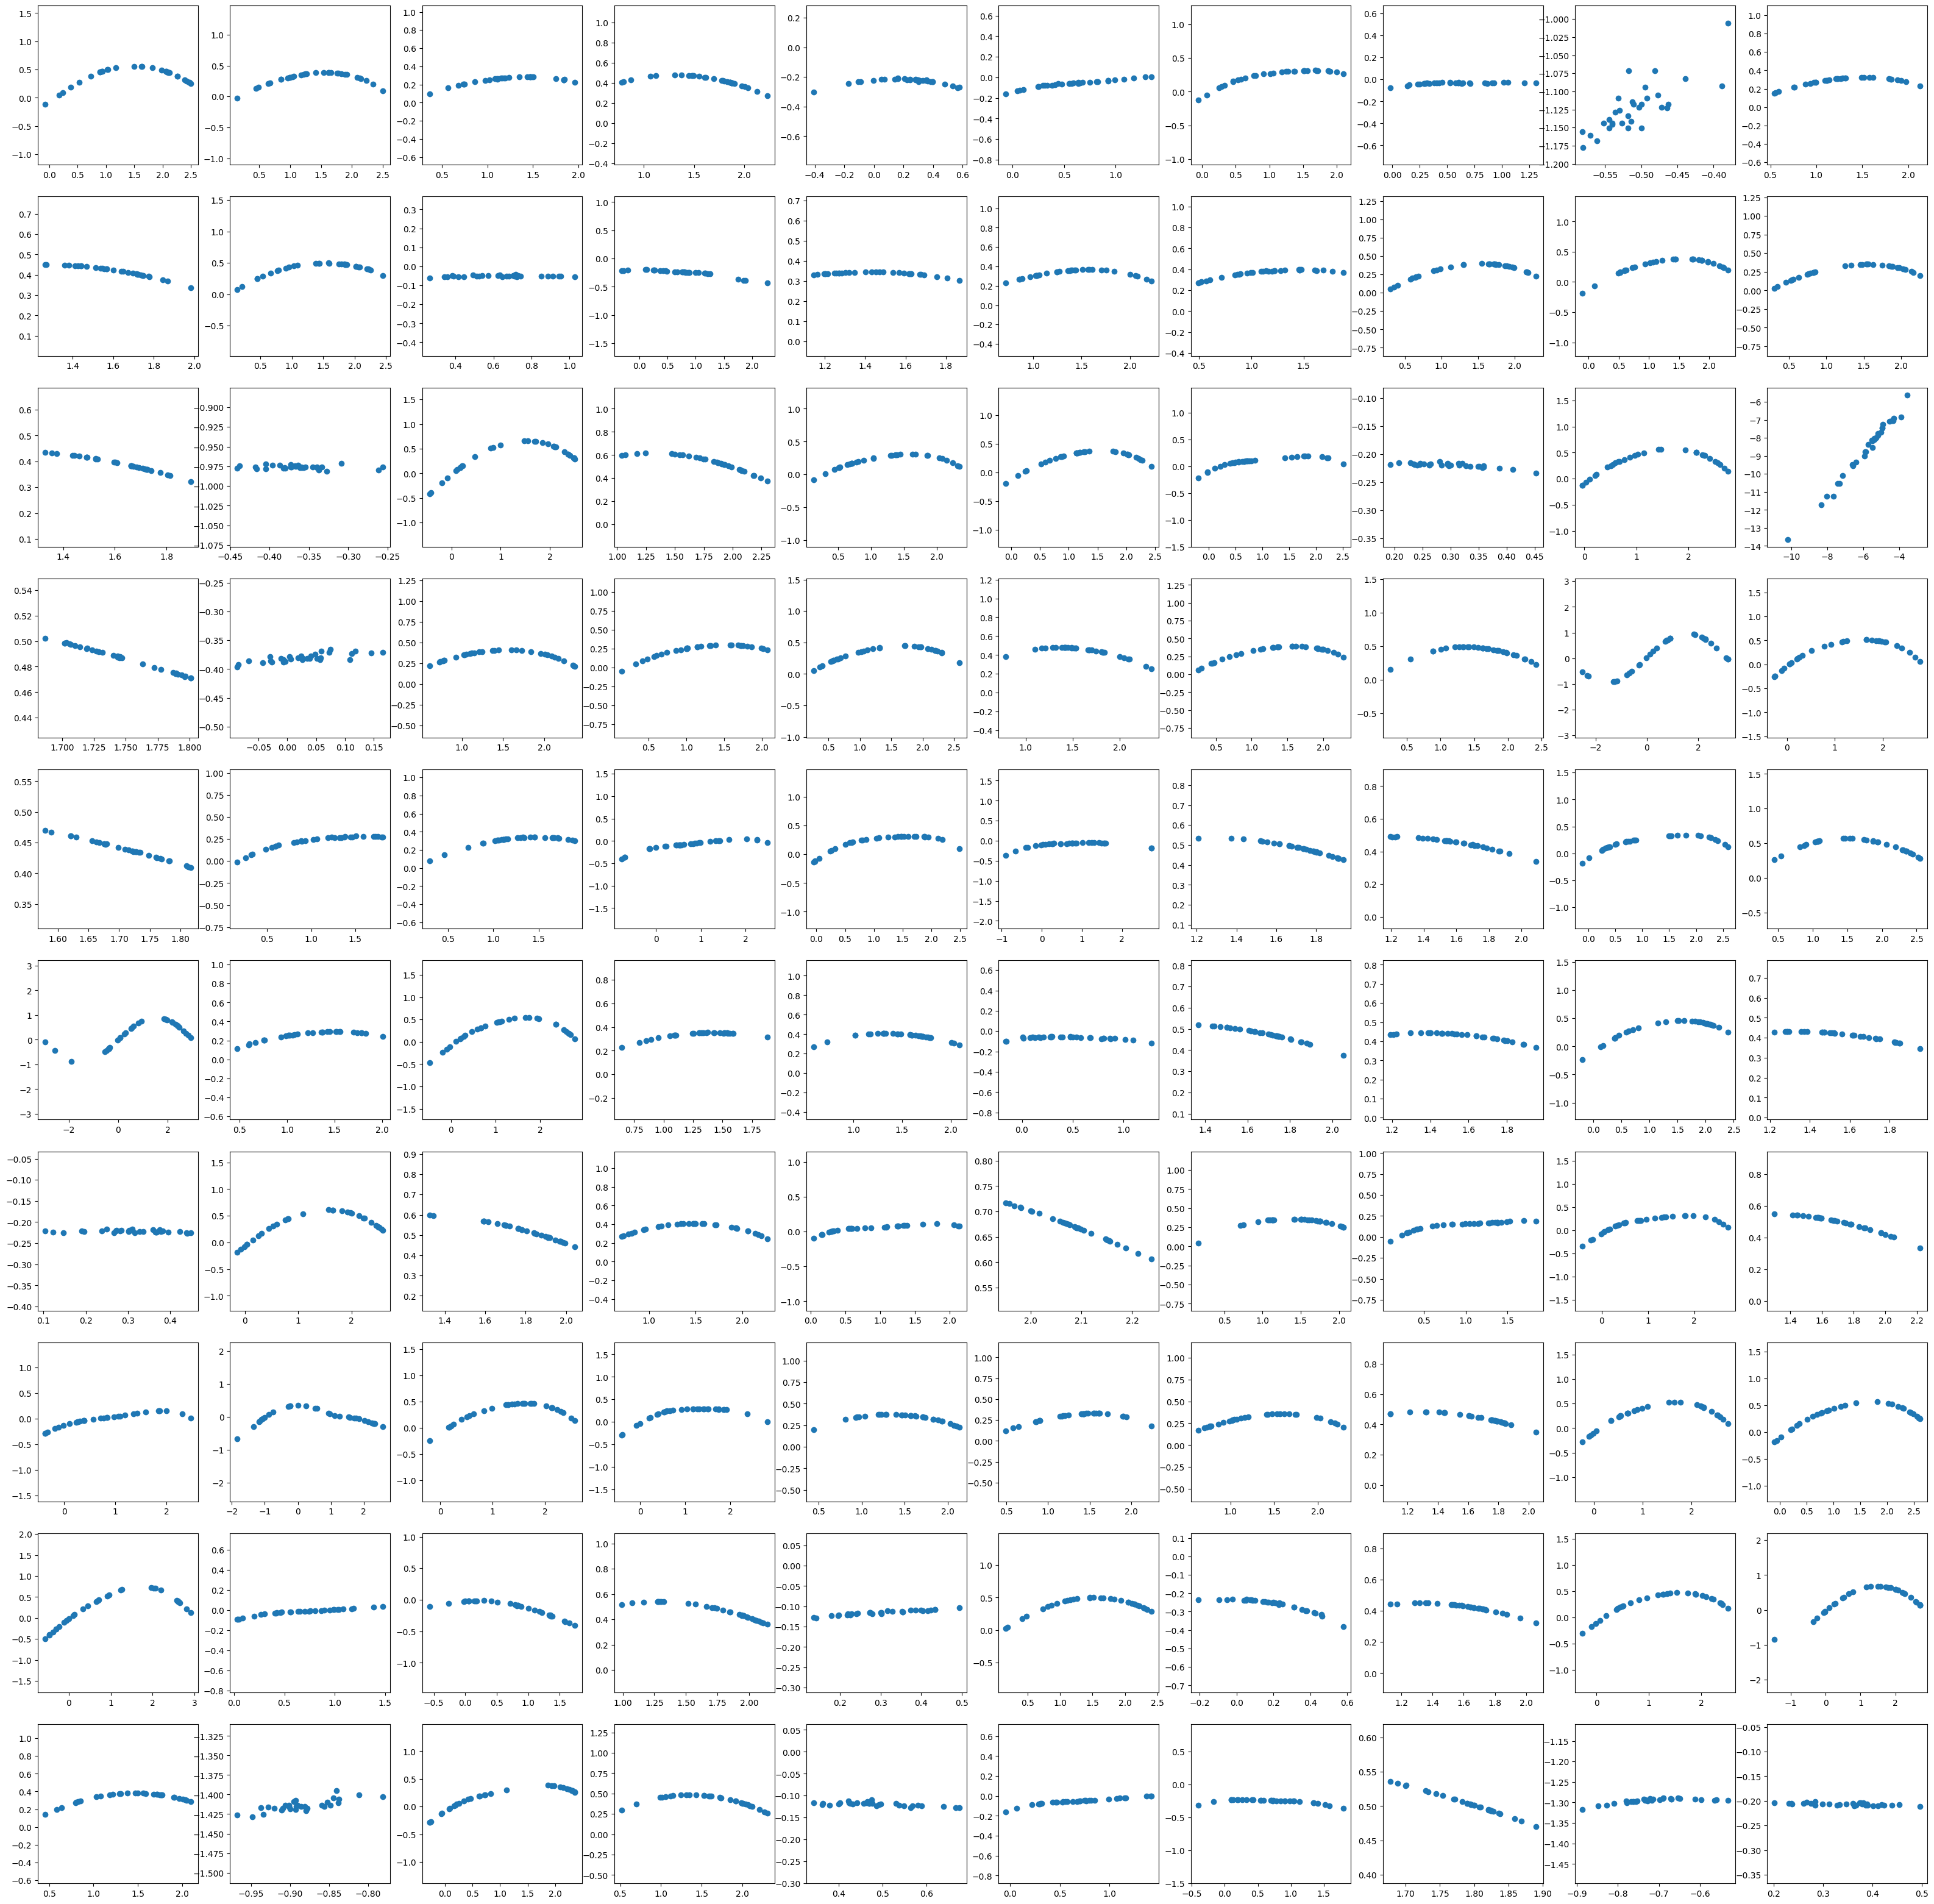

In [9]:
sample = diffusion.p_sample_loop(dit, (100, 2, num_points), clip_denoised=False)
# sample = diffusion.p_sample_loop(dit, (100, num_points, 2), clip_denoised=False)
print(sample.shape)
sample = sample.permute(0, 2, 1)
plot_point_clouds(sample, 10, 10)

In [12]:
sample.shape

torch.Size([100, 2, 16])